In [1]:
#Import all the dependencies

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import ipywidgets as widgets

import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from math_functions import *
from Obstacle import *

# Exercise 1: Implement Bug1 Algorithm (3 pts)

Taking the code of Bug2 algorithm as a starting point, you are asked to implement the Bug1 algorithm (shown below)

![title](Support/images/Bug1.png)

**TODO**:
Complete the main loop. Whithin the main you should add two loops:
- A first loop to find the point $Q$ along the obstacle's boundary that is the the closest to the goal.
- A second loop that circumnavigates the obstacle until $Q$ is reached again
- Once the robot has reached $Q$, it should come back to the main loop and move towards the goal

*Hints*: 
- Use the ``hit_point`` to know when a first path along the obstacle's boundary has been completed
- Keep in memory (using the lists ``boundary_points, goal_distances = [], []``) of all positions and distances to goal along the obstacle's boundary. Use this memory to determine whether the robot has reached $Q$

The following helper functions are provided

In [2]:
# Helper functions
def find_closest_obstacle(position, obstacle_list):
    results = [obs.compute_distance_point_to_polygon(position) for obs in obstacle_list]
    closest_obs = np.argmin([v[0] for v in results])
    return obstacle_list[closest_obs], results[closest_obs]

def has_reached_goal(current_pos, goal, step_size):
    if compute_distance_between_points(current_pos, goal) > step_size:
        return False
    return True

def move_towards_goal(current_pos, goal_pos, step_size):
    direction_to_goal = get_direction_from_points(current_pos, goal_pos)
    next_position = current_pos + step_size * direction_to_goal
    return next_position

def is_about_to_hit_obstacle(next_pos, obstacle_list, step_size):
    _, (closest_obs_distance, obst_segment) = find_closest_obstacle(next_pos, obstacle_list)
    if closest_obs_distance < step_size:
        return True
    return False

## Complete the main loop

**For grading, please make sure that the function``bug1_plan(.)``returns the path found by your Bug1 algorithm. Please do not change the name and signature of the function**



In [3]:
def bug1_plan(initial_robot_pos=None, goal_pos=None, obstacle_list=None, step_size=0.5):
    
    # Set parameters if no defined
    if initial_robot_pos is None:
        initial_robot_pos = [30.0, 40.0]
    
    if goal_pos is None:
        goal_pos = [20.0, 10.0]
        
    if not obstacle_list:
        obstacle1 = Rectangle(origin=np.array([10, 20]), width=30, height=5)
        obstacle2 = Polygon(vertices= np.array([[20, 35], [35, 35], [35, 50], [40, 50],
                                              [40, 30], [20, 30]]))
        obstacle_list = [obstacle1, obstacle2]
        
    # Start algorithm
    robot_path = [initial_robot_pos]
    current_robot_pos = initial_robot_pos
    robot_to_goal_line = compute_line_through_points(current_robot_pos, goal_pos)
    # While goal not reached
    while not has_reached_goal(current_robot_pos, goal_pos, step_size):

        # Move towards goal
        next_robot_pos = move_towards_goal(current_robot_pos, goal_pos, step_size)
        hit_point = np.copy(next_robot_pos)
       # print(hit_point)
        if is_about_to_hit_obstacle(next_robot_pos, obstacle_list, step_size):
            # Go back to current position
            next_robot_pos = current_robot_pos
            boundary_points, goal_distances = [], []
            Q_leave = [0,0]
            while True:
            # Find nearest_obstacle
                closest_obs, (closest_obs_distance, obst_segment) = find_closest_obstacle(next_robot_pos, obstacle_list)
            # Get direction along the obstacle
                direction_around_obstacle = closest_obs.compute_tangent_vector_to_polygon(next_robot_pos, obst_segment)
            # Move in that direction
               
                next_robot_pos = next_robot_pos + step_size * direction_around_obstacle
                boundary_points.append(next_robot_pos) 
                robot_path.append(next_robot_pos)
                goal_distances.append(compute_distance_between_points(next_robot_pos, goal_pos)) 
                Q = np.argmin(goal_distances)
                if (abs(hit_point[0] - next_robot_pos[0])<0.5) and (abs(hit_point[1] - next_robot_pos[1])<0.5):
                    Q_leave = boundary_points[Q]
                  
                if (abs(Q_leave[0] - next_robot_pos[0])<0.5) and (abs(Q_leave[1]-next_robot_pos[1])<0.5):
                    break
                    
                

        # Update current state and add to path
        current_robot_pos = next_robot_pos
        robot_path.append(current_robot_pos)

    ###-------------- Return your path for the grading. Do not change it!! ---------------
    plan = np.array(robot_path)
    return plan
    ###-----------------------------------------------------------------------------------------

##  Test your Code

Use the code provided below to visually test your implementation. If your solution is correct you should obtain a path similar to this one



<IPython.core.display.Javascript object>


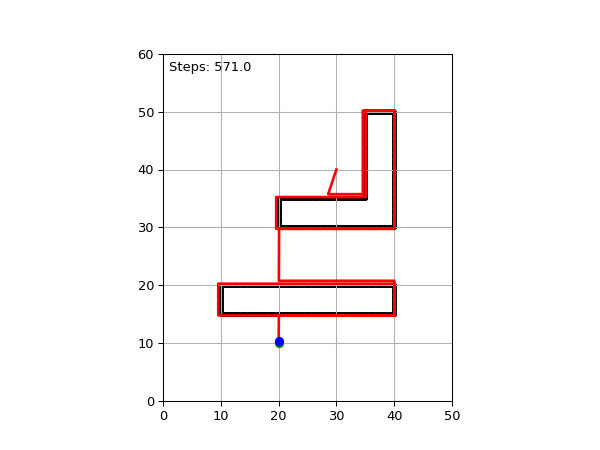

In [5]:
# Run your solution
initial_pos = [30.0, 40.0]
end_pos = [20.0, 10.0]        
robot_step_size = 0.5

obstacle1 = Rectangle(origin=np.array([10, 20]), width=30, height=5)
obstacle2 = Polygon(vertices= np.array([[20, 35], [35, 35], [35, 50], [40, 50],
                                        [40, 30], [20, 30]]))
obstacle_list = [obstacle1, obstacle2]


path = bug1_plan(initial_robot_pos=initial_pos, goal_pos=end_pos, obstacle_list=obstacle_list,
                step_size=robot_step_size)

def plot_obstacles(obstacles, ax):
    for obs in obstacles:
        ox, oy = obs.plot_obstacle()
        ax.scatter(ox, oy, s=7, c='k')

               
# Set plot variables
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, 50), ylim=(0, 60))
ax.grid()

goal, = ax.plot([], [], 'o', lw=2, c='g')
path_line, = ax.plot([], [], 'r', lw=2)
robot, = ax.plot([], [], 'ob', lw=3)
plot_obstacles(obstacle_list, ax)
steps_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# Define the start and goal positions 
g_x, g_y = end_pos
s_x, s_y = initial_pos

if path is not None:
    # Animation code
    def init():
        goal.set_data(g_x, g_y)
        robot.set_data(s_x, s_y)
        path_line.set_data(s_x, s_y)
        steps_text.set_text('')
        return robot, goal, path_line, steps_text

    def animate(i):
        """perform animation step"""
        if i < path.shape[0]:
            pos = path[i,:]
            robot.set_data(pos[0], pos[1])
            path_line.set_data(path[:i, 0], path[:i, 1])
            steps_text.set_text('Steps: %.1f' % i)
        return robot, path_line
    
    ani = animation.FuncAnimation(fig, animate, frames=600, repeat=False, interval=10, init_func=init)
else:
    print("Path was not found!!")